# EECE-571T - Assignment 2

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd gdrive/My Drive/EECE571T_Assignment2/

/content/gdrive/My Drive/EECE571T_Assignment2


### Imports

In [42]:
import time
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
print("Running on torch.__version__ = ", torch.__version__)

torch.backends.cudnn.deterministic = True

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

Running on torch.__version__ =  1.13.1+cu116


### Helper Functions

In [41]:
# a function to move tensors from the CPU to the GPU and vice versa
def dict_to_device(orig, device):
    new = {}
    for k,v in orig.items():
        new[k] = v.to(device)
    return new

# a function to make gray-scale images the same shape as color images
def gray_to_color(x):
    return x.repeat(3, 1, 1)

# a function to plot a batch of images together
def plot_images(img, ax):
    img = torchvision.utils.make_grid(img)
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))  

## Q1

### Dataset and Dataloader

In [53]:
# Use standard MNIST dataset
class MyDataset(torchvision.datasets.MNIST):    
    def __init__(self, *args, debug=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.debug = debug
    
    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        img = data[0]
        label = data[1]
        return {'image': img, 'label': label}
    
    def __len__(self):
        return super().__len__()

dataset = MyDataset(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
    debug=True,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

### ToDo: train, validation, test split

The standard MNIST dataset does not provide a validation set. Use 20% of the training data as the validation set.

The standard MNIST dataset has a test set, and you can download it similar to downloading the train set, only by setting the train label to 'False'. Use the test set only for final the evaluation.

In [54]:
# ToDo: load the test set
test_dataset = MyDataset(
    root = './',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ]),
)

In [55]:
# ToDo: split the training data into train and validation, and define the dataloaders
# Define the size of training/validation set
train_size =  int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Now we can define the dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 64,
    shuffle = True, # ensures the data is randomized to reduce bias
    num_workers = 0
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 64,
    shuffle = False,
    num_workers = 0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 64,
    shuffle = False,
    num_workers = 0
)

In [56]:
# ToDo: print the size of train, validation, and test sets
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 48000
Validation size: 12000
Test size: 10000


### Network

In [57]:
# an example of using available models in PyTorch
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet18 = torchvision.models.resnet18(num_classes=10)
    
    def forward(self, input_dict):        
        pred_label = self.resnet18(input_dict['image'])
        return {'label': pred_label}

# a simple CNN model, implemented from the scratch
class MyNetwork(nn.Module):    
    def __init__(self):
        super(MyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)        
        self.fc = nn.Linear(32*26*26, 10)
        
    def forward(self, input_dict):                 
        x = self.conv1(input_dict['image'])
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        pred_label = nn.functional.log_softmax(x, dim=1)

        return {'label': pred_label}

# You can choose either of the defined networks, or define your own neural net
network = MyNetwork().to('cuda')
print(network)

MyNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=21632, out_features=10, bias=True)
)


### Training

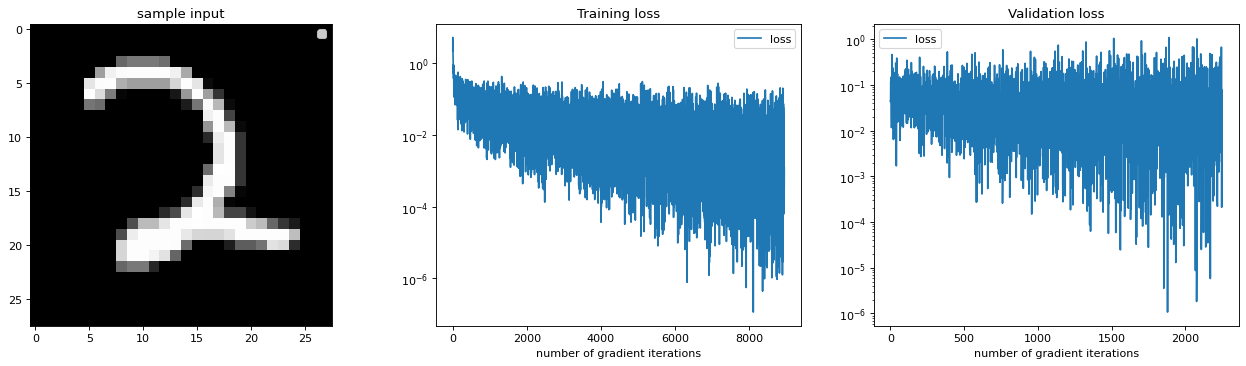

Validation epoch 11, iteration 180 of 188 (95 %), loss=0.07657737284898758


In [58]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.003)

num_epochs = 12
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):        
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss and backward the gradient
        loss = nn.CrossEntropyLoss()(pred['label'], batch_gpu['label'])        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())           

        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            

            # plot some sample image inputs
            plot_images(batch_cpu['image'][0:1], ax=axes[0])    
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))            

    val_iter = iter(val_loader)
    network.eval()    
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = nn.CrossEntropyLoss()(pred['label'], batch_gpu['label'])        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[2].cla()            

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))            
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [59]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')        
        pred = network(batch_gpu)['label'].argmax(dim=1, keepdim=True)                                         
        correct += pred.eq(batch_gpu['label'].view_as(pred)).sum().item()        
        total += pred.shape[0]
           
    return correct / total

In [60]:
# ToDo: report accuracy on train, validation, and test sets
train_acc = get_accuracy(network, train_loader)
val_acc = get_accuracy(network, val_loader)
test_acc = get_accuracy(network, test_loader)

print("Accuracy on train set: {:.2f}%".format(train_acc*100))
print("Accuracy on validation set: {:.2f}%".format(val_acc*100))
print("Accuracy on test set: {:.2f}%".format(test_acc*100))

Accuracy on train set: 99.62%
Accuracy on validation set: 98.22%
Accuracy on test set: 98.43%


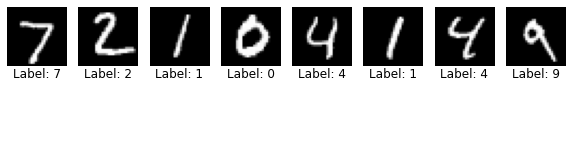

In [61]:
# ToDo: Plot the input images and output of your network for a few samples in the test set
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set network to eval mode
network.eval()

# get some test samples
test_iter = iter(test_loader)
test_batch = next(test_iter)
test_batch_gpu = dict_to_device(test_batch, device)

# predict on test samples
with torch.no_grad():
    test_pred = network(test_batch_gpu)

# get the predicted labels
test_pred_labels = torch.argmax(test_pred['label'], dim=1)

# plot the input images and predicted labels
fig, axes = plt.subplots(2, 8, figsize=(10, 2.7))

for i in range(8):
    # plot input image
    axes[0, i].imshow(test_batch['image'][i].permute(1, 2, 0))
    axes[0, i].axis('off')
    #axes[0, i].set_title(f'Input: {test_batch["label"][i].item()}')
    
    # plot output label
    #axes[1, i].imshow(test_pred['label'][i].cpu(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Label: {test_batch["label"][i].item()}')

plt.show()


## Q2

### Dataset and Dataloader

In [62]:
# Use standard MNIST dataset
class AnomalyDataset(torch.utils.data.Dataset):
    def __init__(self, data):          
        self.data = data
        self.digits = {0:[], 1:[], 2:[], 3:[], 4:[]}        
        for idx in range(len(self.data)):    
            digit = self.data[idx][1]
            if digit in self.digits.keys():
                self.digits[digit].append(idx)        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):      
        norm, anomaly = random.sample(self.digits.keys(), k=2)
        anomaly_loc, = random.sample([0, 1, 2], k=1)
        norm1_idx, norm2_idx = random.sample(self.digits[norm], k=2)
        anomaly_idx, = random.sample(self.digits[anomaly], k=1)
        if anomaly_loc == 0:
            img0 = self.data[anomaly_idx][0]
            img1 = self.data[norm1_idx][0]
            img2 = self.data[norm2_idx][0]
        elif anomaly_loc == 1:
            img0 = self.data[norm1_idx][0]
            img1 = self.data[anomaly_idx][0]
            img2 = self.data[norm2_idx][0]
        elif anomaly_loc == 2:
            img0 = self.data[norm1_idx][0]
            img1 = self.data[norm2_idx][0]
            img2 = self.data[anomaly_idx][0]          

        return {'img0': img0, 'img1': img1, 'img2': img2, 'index': anomaly_loc}        

dataset = AnomalyDataset(torchvision.datasets.MNIST(
    root = './',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
))

loader = torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=0)

In [63]:
print('Selected digits and their frequencies:')
for key, value in loader.dataset.digits.items():
    print(key, len(value))

Selected digits and their frequencies:
0 5923
1 6742
2 5958
3 6131
4 5842


### ToDo: train, validation, test split

Use 20% of the training data as the validation set.

The standard MNIST dataset has a test set, and you can download it similar to downloading the train set, only by setting the train label to 'False'. Use the test set only for final the evaluation.

In [64]:
# ToDo: load the test set
test_dataset = torchvision.datasets.MNIST(
    root='./',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)

In [65]:

# ToDo: define the dataloaders
# Define the size of training/validation set
train_size =  int(0.8 * len(dataset))
val_size = len(dataset) - train_size
[train_dataset, val_dataset] = torch.utils.data.random_split(dataset, [0.8, 0.2])

# Now we can define the dataloaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 128,
    num_workers = 0
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 128,
    num_workers = 0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 128,
    num_workers = 0
)

In [66]:
# ToDo: print the size of train, validation, and test sets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 48000
Validation set size: 12000
Test set size: 10000


### ToDo: Network

Implement a neural network that takes three images as input and returns the index of the image with the different digit.

Your network should take a python dictionary as input and extract the input images from it. Your network should return a python dictionaly containing a key named 'index'.

In [67]:
# ToDo: Implement your neural network from scratch
class MyNetwork(nn.Module):    
    def __init__(self):
        super(MyNetwork, self).__init__()

        # ToDo: code here
        # 9 input channels, 16 output channels, 3x3 kernel
        self.conv1 = nn.Conv2d(9, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.relu1 = nn.ReLU()

        # 16 input channels, 32 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.relu2 = nn.ReLU()

        # 32 input channels, 128 output channels, 3x3 kernel
        self.conv3 = nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.relu3 = nn.ReLU()

        # fully connected layer
        self.fc = nn.Linear(80000, 128)
        self.fc2 = nn.Linear(128, 9216)
        
    def forward(self, input_dict):                         
        img0 = input_dict['img0']        
        img1 = input_dict['img1']
        img2 = input_dict['img2']
        
        # ToDo: code here

        # Hint: use padding in conv layers to adjust the dimensions
        # Hint: max-pooling and ReLU layers can be useful
        # Hint: choose a suitable activation function for the last layer 
        # concatenate the 3 input images
        x = torch.cat((img0, img1, img2), dim=1)

        # apply convolutional layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu3(x)

        # flatten and apply fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.fc2(x)
        pred_index = x

        return {'index': pred_index}

network = MyNetwork().to('cuda')
print(network)

MyNetwork(
  (conv1): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (conv3): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (relu3): ReLU()
  (fc): Linear(in_features=80000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9216, bias=True)
)


### ToDo: Training

In [68]:
# ToDo: define a suitable loss function 
import torch.nn.functional as F

def my_loss_function(predicted_index, target_index):

  # code here
  loss = F.cross_entropy(predicted_index, target_index)

  return loss 

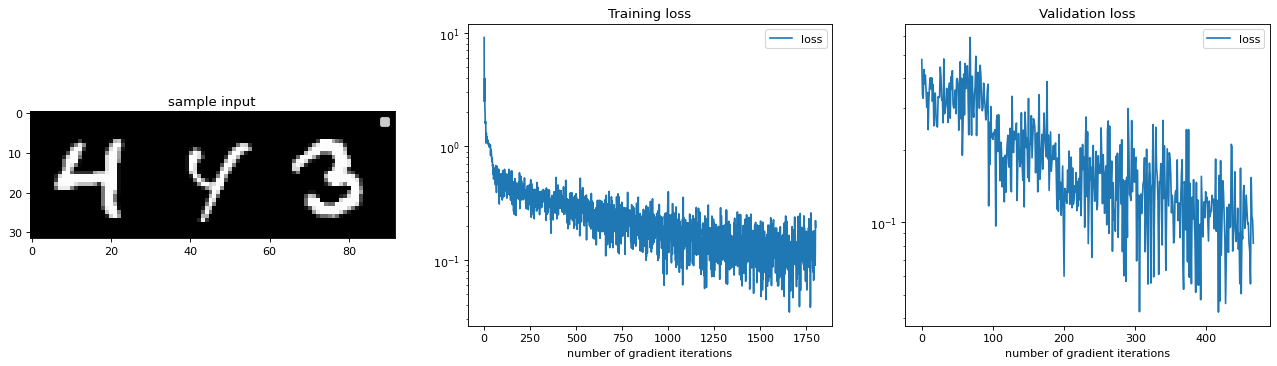

Validation epoch 4, iteration 90 of 94 (95 %), loss=0.08198706060647964


In [69]:
# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,3)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):        
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss and backward the gradient
        loss = my_loss_function(pred['index'], batch_gpu['index'])        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())           

        if i%100==0:            
            axes[0].cla()
            axes[1].cla()            

            # plot some sample image inputs            
            plot_images(torch.cat((batch_cpu['img0'][0:1], batch_cpu['img1'][0:1], batch_cpu['img2'][0:1]), 0), ax=axes[0])    
            axes[0].legend()
            axes[0].set_title('sample input')

            # plot the training error on a log plot
            axes[1].plot(train_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Training loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))            

    val_iter = iter(val_loader)
    network.eval()    
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        
        # calculate the loss
        with torch.no_grad():
            loss = my_loss_function(pred['index'], batch_gpu['index'])        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[2].cla()            

            # plot the validation error on a log plot
            axes[2].plot(val_losses, label='loss')
            axes[2].set_yscale('log')
            axes[2].set_title('Validation loss')
            axes[2].set_xlabel('number of gradient iterations')
            axes[2].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))            
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [70]:
def get_accuracy(network, data_loader):
    network.eval()
    iterator = iter(data_loader)    
    correct = 0
    total = 0
    for i in range(len(iterator)):        
        batch_cpu = next(iterator)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')        
        pred = network(batch_gpu)['index'].argmax(dim=1, keepdim=True)                                         
        correct += pred.eq(batch_gpu['index'].view_as(pred)).sum().item()        
        total += pred.shape[0]
           
    return correct / total

In [ ]:
# ToDo: report accuracy on train, validation, and test sets
train_acc = get_accuracy(network, train_loader)
val_acc = get_accuracy(network, val_loader)
test_acc = get_accuracy(network, test_loader)

print("Accuracy on train set: {:.2f}%".format(train_acc*100))
print("Accuracy on validation set: {:.2f}%".format(val_acc*100))
print("Accuracy on test set: {:.2f}%".format(test_acc*100))

In [ ]:
# ToDo: Plot the input images and output of your network for a few samples in the test set
def plot_images(images, title=None, ax=None):
  ax.imshow(images.permute(1,2,0).cpu().numpy())
  ax.axis('off')
  if title:
        ax.set_title(title)
      
# Get a batch of samples from the test set
samples = next(iter(test_loader))

# Concatenate the three input images
images = torch.cat((samples['img0'], samples['img1'], samples['img2']), 3)

# Send the batch to the GPU
batch_test_gpu = dict_to_device(samples, 'cuda')

# Forward pass through the network
pred_test = network(batch_test_gpu)

# Get the predicted indices for the batch
pred_indices = pred_test['index'].data.max(1, keepdim=True)[1].cpu().numpy()

# Plot a few samples from the batch
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for i in range(3):
    j = random.randint(0, 127)
    # Plot the three input images
    plot_images(images[j], title='Input Images', ax=axes[i, 0])
    # Plot the predicted index
    axes[i, 1].text(0.5, 0.5, f'Predicted Index: {pred_indices[j][0]}', 
                    ha='center', va='center', fontsize=14)
    axes[i, 1].axis('off')

plt.show()

## Q3

### Load and Tokenize Data

In [72]:
data = pd.read_csv('./imdb_processed.csv')
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [73]:
# obtain list of words
words = ' '.join(data.processed.values).split()

# check our list
words[30:40]

[',',
 'show',
 'faint',
 'hearted',
 'timid',
 '.',
 'This',
 'show',
 'pull',
 'punch']

In [74]:
# build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
token2word = dict(enumerate(vocab, 1))
token2word[0] = '<PAD>'
word2token = {word: id for id, word in token2word.items()}

In [75]:

# tokenize reviews
reviews = data.processed.values
reviews_tokenized = [[word2token[word] for word in review.split()] for review in tqdm(reviews)]

# padding sequences
def pad_features(reviews, pad_id, seq_length):    
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    for i, row in enumerate(reviews):        
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

features = pad_features(reviews_tokenized, pad_id=word2token['<PAD>'], seq_length=256)

print('number of reviews:', len(reviews_tokenized))
print('seq_length:', len(features[0]))

# print first-5 words of first 3 reviews
print('\n first-five words of the first-three reviews:')
print('===============')
features[:3, :5]

100%|██████████| 50000/50000 [00:02<00:00, 19168.58it/s]


number of reviews: 50000
seq_length: 256

 first-five words of the first-three reviews:


array([[ 191, 1083,  930,   81, 3724],
       [  47,  328,   59,  244,    1],
       [   3,   95,  328,   30, 1041]])

### Dataloader

In [76]:

# we use 70%, 15%, 15% for train, validation, and test sets
train_size = .7     
val_size = .5
labels = data.label.to_numpy()       

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [77]:

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, labels):                  
        self.data = torch.utils.data.TensorDataset(torch.from_numpy(reviews), torch.from_numpy(labels).float())        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):                                
        review = self.data[index][0]
        label = self.data[index][1]

        return {'review': review, 'label': label}        


train_set = MyDataset(train_x, train_y)
val_set = MyDataset(val_x, val_y)
test_set = MyDataset(test_x, test_y)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=128)
val_loader = torch.utils.data.DataLoader(val_set, shuffle=True, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=128)

### ToDo: Network

Implement a neural network based on Long short-term memory (LSTM) that takes a series of words (a review) as input and returns the label of the review indicating whether it is positive (1) or negative (0).

Your network should take a python dictionary as input and extract the input sentences from it. Your network should return a python dictionaly containing a key named 'label'.

In [78]:

vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 128
output_dim = 1
n_layers = 2
drop_prob = 0.5

In [79]:

# ToDo: Implement your neural network 
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob):
        super(SentimentLSTM, self).__init__()

        # ToDo: code here
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        # Hint: start with an embedding layer
        # Hint: using dropout might be useful       
        # Hint: choose a suitable activation function for the last layer 
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_dim, self.n_layers, 
                            dropout=self.drop_prob, batch_first=True)
        self.dropout = nn.Dropout(self.drop_prob)
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_dict):              
        
         
        x = input_dict['review']
        # ToDo: code here
        # pass the input through the embedding layer
        x = self.embedding(x)
        
        # pass the embeddings through the LSTM layers
        lstm_out, _ = self.lstm(x)
        
        # apply dropout to the LSTM output
        lstm_out = self.dropout(lstm_out)
        
        # pass the LSTM output through the fully connected layer
        fc_out = self.fc(lstm_out[:, -1, :])
        
        # apply sigmoid activation function to get the predicted sentiment label
        pred_label = self.sigmoid(fc_out)
        return {'label': pred_label}

network = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to('cuda')
print(network)

SentimentLSTM(
  (embedding): Embedding(121300, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [80]:

# ToDo: define a suitable loss function 
def my_loss_function(predicted_label, target_label):
  
  # code here
  # The binary cross-entropy loss function
  criterion = nn.BCELoss()
  loss = criterion(predicted_label, target_label.float()) # Convert to float format
  return loss 

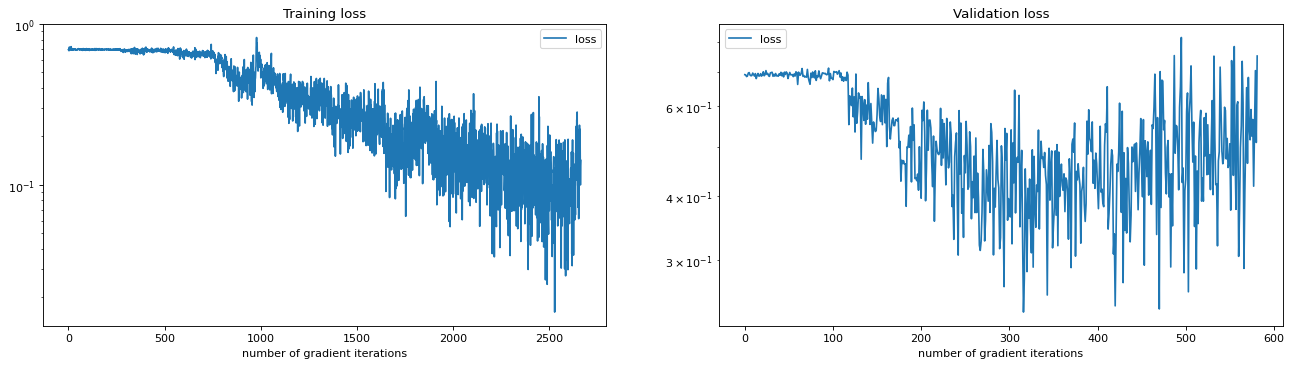

Validation epoch 9, iteration 50 of 59 (84 %), loss=0.7510839104652405


In [81]:

# training loop
%matplotlib inline
from IPython import display

# prepare plotting
fig = plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
axes = fig.subplots(1,2)

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

num_epochs = 10
train_losses = []
val_losses = []

for e in range(num_epochs):
    train_iter = iter(train_loader)
    network.train()
    for i in range(len(train_loader)):        
        batch_cpu = next(train_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        batch_gpu['label'] = batch_gpu['label'].view(-1, 1)

        # calculate the loss and backward the gradient        
        loss = my_loss_function(pred['label'], batch_gpu['label'])        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())           

        if i%100==0:            
            axes[0].cla()                        

            # plot the training error on a log plot
            axes[0].plot(train_losses, label='loss')
            axes[0].set_yscale('log')
            axes[0].set_title('Training loss')
            axes[0].set_xlabel('number of gradient iterations')
            axes[0].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Training epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(train_loader), 100*i//len(train_loader), train_losses[-1]))            

    val_iter = iter(val_loader)
    network.eval()    
    for i in range(len(val_loader)):
        batch_cpu = next(val_iter)
        batch_gpu = dict_to_device(batch_cpu, 'cuda')
        pred = network(batch_gpu)
        pred_cpu = dict_to_device(pred, 'cpu')
        batch_gpu['label'] = batch_gpu['label'].view(-1, 1)

        # calculate the loss
        with torch.no_grad():
            loss = my_loss_function(pred['label'], batch_gpu['label'])        
            val_losses.append(loss.item()) 

        if i%10==0: 
            axes[1].cla()            

            # plot the validation error on a log plot
            axes[1].plot(val_losses, label='loss')
            axes[1].set_yscale('log')
            axes[1].set_title('Validation loss')
            axes[1].set_xlabel('number of gradient iterations')
            axes[1].legend()

            # clear output window and diplay updated figure
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print("Validation epoch {}, iteration {} of {} ({} %), loss={}".format(e, i, len(val_loader), 100*i//len(val_loader), val_losses[-1]))            
plt.close('all')

### ToDo: Evaluation

Here we want to report the accuracy of the network's predictions. We have defined a function named 'get_accuracy' that returns the accuracy of the network on its input data.

Here, we assumed that the network returns class probabilities as output. If your network returns class indices, you might need to change this evaluation function as well.

Print the accuracy of your network for the train, validation, and test sets.

In [ ]:

def get_accuracy(network, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            batch_gpu = {k: v.to(device) for k, v in batch.items()}
            pred = network(batch_gpu)['label']
            binary_pred = torch.where(pred < 0.5, 0, 1).squeeze(-1)
            labels = batch_gpu['label'][:binary_pred.shape[0]]  # select relevant number of labels
            correct += binary_pred.eq(labels).sum().item()
            total += binary_pred.shape[0]
    return correct / total

In [ ]:

#from torch.utils.data import TensorDataset, DataLoader
# ToDo: report accuracy on train, validation, and test sets
train_acc = get_accuracy(network, train_loader)
val_acc = get_accuracy(network, val_loader)
test_acc = get_accuracy(network, test_loader)

print(f"Train accuracy: {train_acc:.2f}")
print(f"Validation accuracy: {val_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")


In [ ]:
# ToDo: print the input review and output of your network for one positive 
#       example and one negative example in the test set
# Select random positive example from test set
pos_example_idx = (test_labels == 1).nonzero().flatten()
pos_example_idx = pos_example_idx[random.randint(0, len(pos_example_idx)-1)]
pos_review = test_dataset[pos_example_idx]['review']
pos_label = test_dataset[pos_example_idx]['label']

# Select random negative example from test set
neg_example_idx = (test_labels == 0).nonzero().flatten()
neg_example_idx = neg_example_idx[random.randint(0, len(neg_example_idx)-1)]
neg_review = test_dataset[neg_example_idx]['review']
neg_label = test_dataset[neg_example_idx]['label']

# Convert examples to tensor and send to device
pos_review = pos_review.to(device)
neg_review = neg_review.to(device)

# Predict labels for examples
with torch.no_grad():
    pos_pred = network(pos_review)['label'].item()
    neg_pred = network(neg_review)['label'].item()

# Print results
print("Positive Example:")
print("------------------")
print("Review:", " ".join([token2word[t.item()] for t in pos_review]))
print("True Label:", pos_label.item())
print("Predicted Label:", round(pos_pred))
print()
print("Negative Example:")
print("------------------")
print("Review:", " ".join([token2word[t.item()] for t in neg_review]))
print("True Label:", neg_label.item())
print("Predicted Label:", round(neg_pred))
